In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [29]:
# 사전 학습된 신경망 모델 불러오기
model=ResNet50(weights='imagenet')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

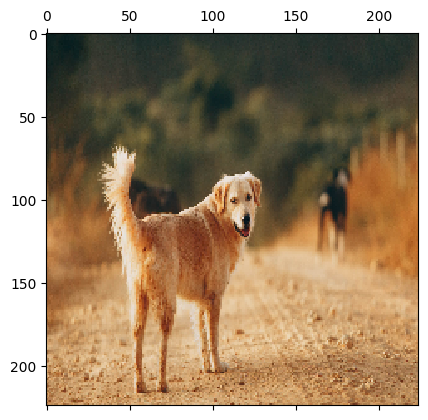

In [30]:
# 영상 불러와 크기 조절 & 화면 디스플레이
image_path = 'dataset/dog.jpg'
img = image.load_img(image_path, target_size = (224,224))
plt.matshow(img)

In [31]:
# 신경망 형태로 변환
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=resnet50.preprocess_input(x)

In [32]:
# 인식하기
preds=model.predict(x)
print("result : ", resnet50.decode_predictions(preds,top=5)[0])

1/1 [==============================] - 1s 806ms/step
result :  [('n02091831', 'Saluki', 0.86146), ('n02099601', 'golden_retriever', 0.117111005), ('n02100877', 'Irish_setter', 0.0054717525), ('n02090622', 'borzoi', 0.0044244006), ('n02389026', 'sorrel', 0.0031950255)]


In [33]:
#신경망 모델의 특 징 추출 부분에서 마지막 층을 지정
#특징 추출 부분만으로 구성된 model_1만들기
last_conv_layer = model.get_layer("conv5_block3_out")
 
model_1= keras.Model(model.inputs, last_conv_layer.output)

In [34]:
#분류 (전역평균풀링 또는 완전연결층) 부분만으로 구성된 model__2만들기
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("avg_pool")(input_2)
x_2 = model.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

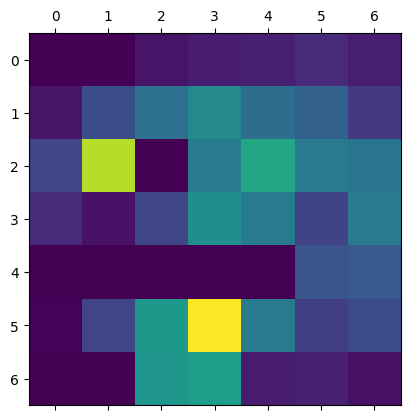

In [35]:
#GradientTape함수를 이용한 그레디언트 계산
with tf.GradientTape() as tape:
    output_1 = model_1(x)
    tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]
 
grads = tape.gradient(output_2, output_1) #그레디언트 계산
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) #식5 적용
 
output_1 = output_1.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*=pooled_grads[i]
heatmap=np.mean(output_1, axis=-1)
 
heatmap =np.maximum(heatmap, 0)/np.max(heatmap) #정규화
plt.matshow(heatmap)

/tmp/ipykernel_28818/4117375694.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet") #jet 컬러맵으로 표시


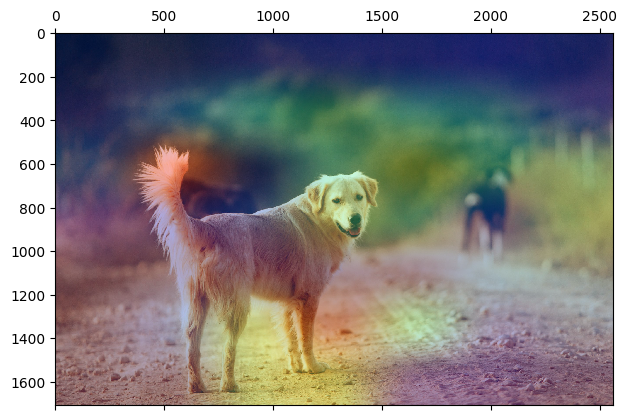

In [36]:
#열지도를 입력 영상에 씌움
img =image.load_img(image_path) #입력 영상을 다시 받음
 
img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환
 
jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
color = jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]
 
color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)
 
overlay_img= color_heatmap*0.4+img #덧씌움
overlay_img = keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)